In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [23]:
df = pd.read_csv('../data/creditcard.csv')

In [24]:
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

df = df.drop(['Time'], axis=1)

In [25]:
# 'Class' is target variable
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [26]:
print(y_train.value_counts(normalize=True))

Class
0    0.998222
1    0.001778
Name: proportion, dtype: float64


In [28]:
xgb_clf = xgb.XGBClassifier()

In [30]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [31]:
# Evaluate initial model's performance
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

In [32]:
print(classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_xgb)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.93      0.77      0.84        87

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9995611109160493
ROC AUC: 0.975560944802324


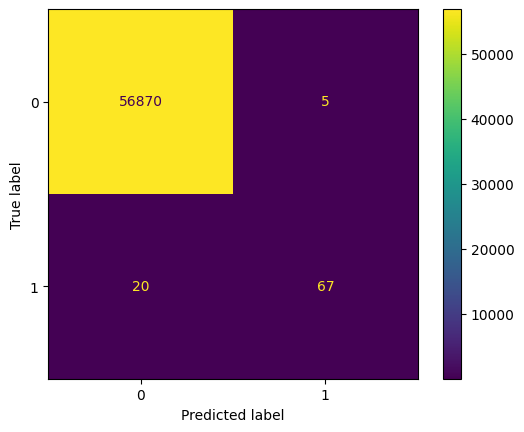

In [33]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

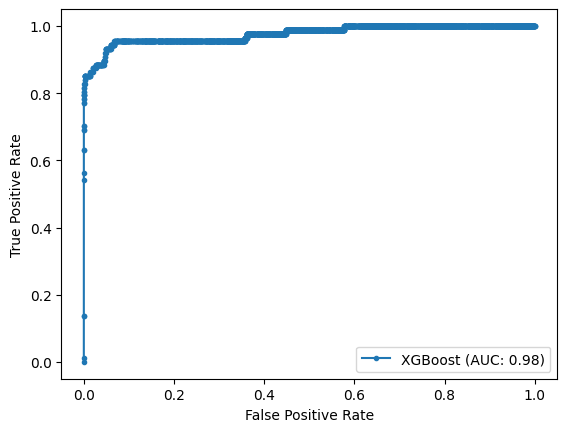

In [34]:
# ROC curve visualization
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.plot(fpr, tpr, marker='.', label=f'XGBoost (AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [35]:
# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(50, 400, 50),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': np.arange(3, 10, 1),
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=25,
    scoring='roc_auc',
    n_jobs=-1,
    cv=3,
    random_state=1
)

random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best Score: 0.9821218950220215


In [40]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.6,
    gamma=0.1,
    reg_alpha=0.01,
    reg_lambda=1.0,
    eval_metric="auc",
    use_label_encoder=False,  # Explicitly set to avoid another common warning
    # You can uncomment the following line if you decide to use the 'dart' booster
    # booster='dart'
)

# Set early stopping rounds via set_params
xgb_clf.set_params(early_stopping_rounds=10)

# Prepare the evaluation set in the format expected by the early stopping
eval_set = [(X_test, y_test)]

# Fit the model, while evaluation metrics are now taken from the constructor/set_params
xgb_clf.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Retrieve the best iteration number after fit
best_n_estimators = xgb_clf.best_iteration + 1  # Adding 1 because best_iteration is 0-indexed

# Update the model's n_estimators to the best iteration
xgb_clf.set_params(n_estimators=best_n_estimators)


[0]	validation_0-auc:0.89550
[1]	validation_0-auc:0.90106
[2]	validation_0-auc:0.91727
[3]	validation_0-auc:0.91730
[4]	validation_0-auc:0.92211
[5]	validation_0-auc:0.92211
[6]	validation_0-auc:0.92214
[7]	validation_0-auc:0.92203
[8]	validation_0-auc:0.92204
[9]	validation_0-auc:0.92206
[10]	validation_0-auc:0.92206
[11]	validation_0-auc:0.92209
[12]	validation_0-auc:0.92209
[13]	validation_0-auc:0.92209
[14]	validation_0-auc:0.92209
[15]	validation_0-auc:0.94125
[16]	validation_0-auc:0.94125
[17]	validation_0-auc:0.94094
[18]	validation_0-auc:0.94093
[19]	validation_0-auc:0.94091
[20]	validation_0-auc:0.93984
[21]	validation_0-auc:0.94507
[22]	validation_0-auc:0.94511
[23]	validation_0-auc:0.95015
[24]	validation_0-auc:0.96469
[25]	validation_0-auc:0.96479
[26]	validation_0-auc:0.96863
[27]	validation_0-auc:0.96837
[28]	validation_0-auc:0.96880
[29]	validation_0-auc:0.96842
[30]	validation_0-auc:0.96810
[31]	validation_0-auc:0.96850
[32]	validation_0-auc:0.96824
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=88, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [41]:
from sklearn.model_selection import cross_val_score

# Assuming the best parameters from previous tuning
xgb_clf = xgb.XGBClassifier(
    subsample=0.6,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    colsample_bytree=0.6
)

# Perform cross-validation to check the robustness of the model
cv_scores = cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='roc_auc')
print(f"CV AUC Scores: {cv_scores}")
print(f"Mean CV AUC Score: {cv_scores.mean()}")

# If cross-validation scores are satisfactory, refit the model on the full training data
xgb_clf.fit(X_train, y_train)

# After fitting, you can extract feature importances and make further decisions on feature engineering
feature_importances = xgb_clf.feature_importances_
# Consider plotting feature importances or further analysis


CV AUC Scores: [0.98340384 0.98328714 0.98078478 0.98460237 0.98731547]
Mean CV AUC Score: 0.983878722050694


In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Predictions with the XGBoost model
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Calculate the metrics
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_score_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

# Print the metrics in the desired format
print(f"XGBoost Model Performance")
print(f"Precision: {precision_xgb:.2f}")
print(f"Recall: {recall_xgb:.2f}")
print(f"F1-Score: {f1_score_xgb:.2f}")
print(f"ROC AUC: {roc_auc_xgb:.2f}")


XGBoost Model Performance
Precision: 0.92
Recall: 0.76
F1-Score: 0.83
ROC AUC: 0.99
